In [12]:
# Ref : https://github.com/developer0hye/Custom-CNN-based-Image-Classification-in-PyTorch

import torch
import torch.nn as nn
import numpy as np
import torchvision
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import os
from PIL import Image

# Data
validation_split =  0.2
shuffle_dataset = True
random_seed = 42
# image_dir = './Data/resized'
image_dir = './Data/images/images'

# Initial Value
batch_size = 8
num_epochs = 10
learning_rate = 0.00001

# Running Type : debug / Operation
# running_type = "Operation"
running_type = "debug"

# data_type : drawing / cifar10 / kuroro
data_type = "drawing"
# data_type = "cifar10"
# data_type = "kuroko"

In [13]:
# Image Resizing
img_h, img_w = 128, 128
imgs = []
imgs_label = []

class CustomImageDataset(Dataset):
    def read_dataset(self):

        all_img_files = []
        all_labels = []
        all_class_names = set()
        
        # for debug
        now = 0
        count = 0
        
        class_names = os.walk(self.dataset_path).__next__()[1]        
        
        for index, class_name in enumerate(class_names):
            label = index
            img_dir = os.path.join(self.dataset_path, class_name)
            img_files = os.walk(img_dir).__next__()[2]

            for img_file in img_files:
                img_file = os.path.join(img_dir, img_file)
                img = Image.open(img_file)
                if running_type == "debug":
                    if label+1 > 5:
                        break;
                    if count < 1000:
                        all_img_files.append(img_file)
                        all_labels.append(label)
                        all_class_names.add(class_name)
                    elif now != label:
                        now = label
                        count = -1
                    
                    count += 1
                else:
                    if img is not None:
                        all_img_files.append(img_file)
                        all_labels.append(label)
                        all_class_names.add(class_name)
                    
        
        return all_img_files, all_labels, len(all_img_files), len(all_class_names)

    def __init__(self, dataset_path, transforms=None):
        self.dataset_path = dataset_path
        self.image_files_path, self.labels, self.length, self.num_classes = self.read_dataset()
        self.transforms = transforms

    def __getitem__(self, index):
        image = Image.open(self.image_files_path[index])
        image = image.convert("RGB")

        if self.transforms is not None:
            image = self.transforms(image)

        return {'image': image, 'label': self.labels[index]}

    def __len__(self):
        return self.length

In [14]:
if data_type == "drawing":
    transforms = transforms.Compose([transforms.Resize((img_h, img_w)),
                                           transforms.RandomRotation(10.),
                                           transforms.ToTensor()])

    # Split data to train and validation
    dataset = CustomImageDataset(dataset_path=image_dir, transforms=transforms)

    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    split = int(np.floor(validation_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    valid_sampler = SubsetRandomSampler(val_indices)


    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                               sampler=train_sampler)
    validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=valid_sampler)

elif data_type == "cifar10":
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    trainset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=True,
                                            download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data_cifar10', train=False,
                                           download=True, transform=transform)
    validation_loader = torch.utils.data.DataLoader(testset, batch_size=4,
                                             shuffle=False, num_workers=2)
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    trainset.num_classes = len(classes)
elif data_type == "kuroko":
    transforms_train = transforms.Compose([transforms.Resize((128, 128)),
                                           transforms.RandomRotation(10.),
                                           transforms.ToTensor()])

    transforms_test = transforms.Compose([transforms.Resize((128, 128)),
                                          transforms.ToTensor()])

    trainset = CustomImageDataset(dataset_path="./data_kuroko/train", transforms=transforms_train)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    testset = CustomImageDataset(dataset_path="./data_kuroko/test", transforms=transforms_test)
    validation_loader = DataLoader(testset, batch_size=batch_size, shuffle=True)

All data length : 1247 = 998(train) + 249(test)
num_classes :  5


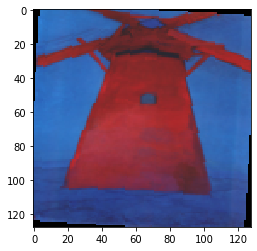

In [15]:
import matplotlib.pyplot as plt
if data_type == "drawing":
    print("All data length : {} = {}(train) + {}(test)" .format(len(dataset), train_indices.__len__(), val_indices.__len__()))
    print("num_classes : ", dataset.num_classes)
    plt.imshow(dataset[2].get('image').permute(1, 2, 0)); # 이미지 그리기
elif data_type == "cifar10":
    print("train length : ", len(trainset))
    print("validation length : " , len(testset))
    print("class length : ", trainset.num_classes)
if data_type == "kuroko":
    print("All data length : {} = {}(train) + {}(test)" .format(len(trainset) + len(testset), len(trainset),  len(testset)))
    print("num_classes : ", trainset.num_classes)
    plt.imshow(trainset[2].get('image').permute(1, 2, 0)); # 이미지 그리기

# for i_batch, item in enumerate(train_loader):
#     print(item['label'])
    
# for i_batch, item in enumerate(validation_loader):
#     print(item['label'])

In [16]:
# Model : VGG19
class VGG19(nn.Module):
    def __init__(self, num_classes):
        super(VGG19, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.FC1 = nn.Sequential(
#             nn.Linear(512, 4096),
            nn.Linear(8192, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU())

        self.FC2 = nn.Sequential(
            nn.Linear(4096, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU())

        self.FC3 = nn.Sequential(
            nn.Linear(4096, num_classes),
            nn.BatchNorm1d(num_classes),
            nn.Softmax())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(out.size(0), -1)
#         print("out : ", out.shape)
        out = self.FC1(out)
        out = self.FC2(out)
        out = self.FC3(out)
        return out

In [17]:
# Optimizer : Adam
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)

        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2 ** self.iter) / (1.0 - self.beta1 ** self.iter)

        for key in params.keys():
            # self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            # self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)


In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if data_type=="drawing":
    num_classes = dataset.num_classes
elif data_type ==  "kuroro":
    num_classes = trainset.num_classes
vgg19 = VGG19(num_classes=num_classes).to(device)

# Loss Function
Loss_function = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(vgg19.parameters(), lr=learning_rate)
# optimizer = Adam()

In [19]:
total = 0
correct = 0
correct_mid = 0 

for e in range(num_epochs):
    for i_batch, item in enumerate(train_loader): # i_batch : i번째 batch, item : 해당 item, batch_size개
        images = item['image'].to(device)
        labels = item['label'].to(device)

        # Forward pass
        outputs = vgg19(images)
        loss = Loss_function(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 중간 집계
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += len(labels)        

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))
    print('Epoch [{}/{}], Loss: {:.4f}' .format(e + 1, num_epochs, loss.item()))
    correct = 0
    total = 0

Test Accuracy of the model on the 998 test images: 51.503006012024045 %
Epoch [1/10], Loss: 1.4599
Test Accuracy of the model on the 998 test images: 59.519038076152306 %
Epoch [2/10], Loss: 1.3749
Test Accuracy of the model on the 998 test images: 64.62925851703407 %
Epoch [3/10], Loss: 1.4294
Test Accuracy of the model on the 998 test images: 66.63326653306613 %
Epoch [4/10], Loss: 1.3536
Test Accuracy of the model on the 998 test images: 68.13627254509018 %
Epoch [5/10], Loss: 1.4051
Test Accuracy of the model on the 998 test images: 69.13827655310621 %
Epoch [6/10], Loss: 1.3740
Test Accuracy of the model on the 998 test images: 70.54108216432866 %
Epoch [7/10], Loss: 1.3579
Test Accuracy of the model on the 998 test images: 72.54509018036072 %
Epoch [8/10], Loss: 1.3713
Test Accuracy of the model on the 998 test images: 73.44689378757515 %
Epoch [9/10], Loss: 1.3982
Test Accuracy of the model on the 998 test images: 73.94789579158316 %
Epoch [10/10], Loss: 1.2343


In [20]:
# Test the model
vgg19.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
#    for item in train_loader:
    for item in validation_loader:
        images = item['image'].to(device)
        labels = item['label'].to(device)
        outputs = vgg19(images)
        _, predicted = torch.max(outputs.data, 1)
        total += len(labels)
        correct += (predicted == labels).sum().item()
        print("{} (labels) vs {} (predicted) " .format(labels, predicted))

    print('Test Accuracy of the model on the {} test images: {} %'.format(total, 100 * correct / total))

tensor([4, 2, 2, 2, 2, 4, 0, 2]) (labels) vs tensor([4, 2, 2, 2, 2, 4, 0, 2]) (predicted) 
tensor([2, 2, 2, 2, 4, 2, 2, 2]) (labels) vs tensor([2, 2, 2, 2, 4, 2, 2, 2]) (predicted) 
tensor([4, 1, 1, 4, 1, 2, 1, 4]) (labels) vs tensor([4, 1, 1, 4, 1, 1, 1, 4]) (predicted) 
tensor([4, 4, 4, 3, 2, 1, 2, 2]) (labels) vs tensor([4, 4, 1, 3, 2, 3, 1, 2]) (predicted) 
tensor([4, 0, 2, 2, 4, 0, 2, 1]) (labels) vs tensor([4, 0, 2, 2, 4, 0, 2, 1]) (predicted) 
tensor([1, 2, 2, 3, 2, 1, 2, 0]) (labels) vs tensor([1, 2, 2, 3, 2, 1, 3, 1]) (predicted) 
tensor([2, 2, 2, 4, 2, 2, 4, 1]) (labels) vs tensor([1, 2, 2, 4, 2, 2, 4, 4]) (predicted) 
tensor([2, 3, 2, 2, 1, 2, 1, 2]) (labels) vs tensor([2, 3, 2, 2, 1, 2, 1, 1]) (predicted) 
tensor([2, 2, 2, 4, 2, 2, 2, 2]) (labels) vs tensor([2, 2, 2, 4, 2, 2, 2, 2]) (predicted) 
tensor([4, 2, 3, 4, 2, 0, 1, 2]) (labels) vs tensor([4, 2, 2, 4, 2, 0, 1, 2]) (predicted) 
tensor([2, 2, 2, 2, 0, 4, 2, 4]) (labels) vs tensor([2, 2, 2, 0, 0, 4, 1, 4]) (predicted) 

1

1